In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from datetime import datetime
from tqdm import tqdm_notebook
import os
import glob
from abc import ABCMeta, abstractmethod

In [3]:
dataSaveDir = os.getenv('OANDA_DATA_MAIN')

In [4]:
df = pd.read_hdf(os.path.join(dataSaveDir, 'AUD_USD_170101_170101_1H.h5s'))

In [5]:
dfSMA = pd.DataFrame(index=df.index, columns=['bid','ask','shortSMA', 'longSMA', 'openPosition'])
dfSMA['bid'] = df.closeBid
dfSMA['ask'] = df.closeAsk
dfSMA['openPosition'] = False
shortWindow, longWindow = 10, 50

In [6]:
dfSMA['shortSMA'] = dfSMA.bid.shift(1).rolling(window=shortWindow,).mean()
dfSMA['longSMA'] = dfSMA.bid.shift(1).rolling(window=longWindow).mean()
dfSMA.dropna(inplace=True)

In [7]:
dfSMA['shortSMMA'] = False
dfSMA['longSMMA'] = False
dfSMA.head()

,bid,ask,shortSMA,longSMA,openPosition,shortSMMA,longSMMA
2017-01-05 01:00:00,0.72822,0.72835,0.727793,0.723952,False,False,False
2017-01-05 02:00:00,0.72828,0.72843,0.727801,0.724126,False,False,False
2017-01-05 03:00:00,0.72925,0.72940,0.727939,0.724304,False,False,False
2017-01-05 04:00:00,0.73004,0.73020,0.728166,0.724457,False,False,False
2017-01-05 05:00:00,0.73083,0.73098,0.728457,0.724610,False,False,False


In [8]:
dfSMA.loc[:1,'longSMMA'] = dfSMA.bid[0]
dfSMA.loc[:1, 'shortSMMA'] = dfSMA.bid[0]

In [9]:
dfSMA.head()

,bid,ask,shortSMA,longSMA,openPosition,shortSMMA,longSMMA
2017-01-05 01:00:00,0.72822,0.72835,0.727793,0.723952,False,0.72822,0.72822
2017-01-05 02:00:00,0.72828,0.72843,0.727801,0.724126,False,0.00000,0.00000
2017-01-05 03:00:00,0.72925,0.72940,0.727939,0.724304,False,0.00000,0.00000
2017-01-05 04:00:00,0.73004,0.73020,0.728166,0.724457,False,0.00000,0.00000
2017-01-05 05:00:00,0.73083,0.73098,0.728457,0.724610,False,0.00000,0.00000


In [10]:
for i in range(1, dfSMA.shape[0]):
    idx = dfSMA.index[i]
    dfSMA.loc[idx, 'shortSMMA'] = (dfSMA.shortSMMA[i-1] * (shortWindow - 1) +
                                  dfSMA.bid[i]) / shortWindow
    dfSMA.loc[idx, 'longSMMA'] = (dfSMA.longSMMA[i-1] * (longWindow - 1) +
                                dfSMA.bid[i]) / longWindow

In [11]:
dfSMA.head()

,bid,ask,shortSMA,longSMA,openPosition,shortSMMA,longSMMA
2017-01-05 01:00:00,0.72822,0.72835,0.727793,0.723952,False,0.728220,0.728220
2017-01-05 02:00:00,0.72828,0.72843,0.727801,0.724126,False,0.728226,0.728221
2017-01-05 03:00:00,0.72925,0.72940,0.727939,0.724304,False,0.728328,0.728242
2017-01-05 04:00:00,0.73004,0.73020,0.728166,0.724457,False,0.728500,0.728278
2017-01-05 05:00:00,0.73083,0.73098,0.728457,0.724610,False,0.728733,0.728329


In [35]:
dfPosition = pd.DataFrame(columns=["tradeNo", "type", "openDateTime", "openPrice", 
                                   "closeDateTime", "closePrice", "PnL"])
dfPortfolio = pd.DataFrame(columns=["closeDatetime", "equity", "returns"])

In [25]:
def GetValuePerPip(unitsTraded, accCur='USD', pairTraded='EUR_USD', direction="long",
               quoteCur_accCur_spotRate=None):
    #use quote currency to determine val. per pip
    pip = 1e-4
    mult = 1
    if direction == "short":
        mult = -1
    val_per_pip_quoteCur =  mult * unitsTraded * pip
    if accCur == pairTraded.split('_')[1]:
        convRate = 1
    else:
        convRate = quoteCur_accCur_spotRate
    val_per_pip = convRate * val_per_pip_quoteCur
    return val_per_pip

In [ ]:
def GetTradeRiskVal(equity, risk=0.01)

In [24]:
if None:
    print('yes')

In [32]:
def GetPnL(posRow):
    return posRow['closePrice'] - posRow['openPrice'] 

In [37]:
tradeno = 0
for i in range(1, dfSMA.shape[0]):
    prevrow = dfSMA.iloc[i-1,:]
    row = dfSMA.iloc[i,:]
    if row.shortSMA > row.longSMA:
        if not prevrow['openPosition']:
            # no trade open, open long
            posType = "long"
            dfSMA.loc[dfSMA.index[i], 'openPosition'] = posType
            dfPosition.loc[tradeno, 'tradeNo'] = tradeno 
            dfPosition.loc[tradeno, 'type'] = posType
            dfPosition.loc[tradeno, 'openDateTime'] = row.name
            dfPosition.loc[tradeno, 'openPrice'] = row.ask
        elif prevrow['openPosition'].lower() == 'short':
            # short trade open, close it
            dfSMA.loc[dfSMA.index[i], 'openPosition'] = False
            dfPosition.loc[tradeno, 'closePrice'] = row.ask
            dfPosition.loc[tradeno, 'closeDateTime'] = row.name
            dfPosition.loc[tradeno, 'PnL'] = GetPnL(dfPosition.loc[tradeno, :])
            # update portfolio
            tradeno += 1
    elif row.shortSMA < row.longSMA:
        if not prevrow['openPosition']:
            # open short trade
            posType = "short"
            dfSMA.loc[dfSMA.index[i], 'openPosition'] = posType
            dfPosition.loc[tradeno, 'tradeNo'] = tradeno
            dfPosition.loc[tradeno, 'type'] = posType
            dfPosition.loc[tradeno, 'openDateTime'] = row.name
            dfPosition.loc[tradeno, 'openPrice'] = row.bid
        elif prevrow['openPosition'].lower() == "long":
            # close open long trade
            dfSMA.loc[dfSMA.index[i], 'openPosition'] = False
            dfPosition.loc[tradeno, 'closePrice'] = row.bid
            dfPosition.loc[tradeno, 'closeDateTime'] = row.name
            dfPosition.loc[tradeno, 'PnL'] = GetPnL(dfPosition.loc[tradeno, :])
            # update portfolio
            tradeno+=1

In [38]:
row = dfPosition.loc[4,:]

In [39]:
row

tradeNo                            4
type                            long
openDateTime     2017-02-01 22:00:00
openPrice                    0.75814
closeDateTime    2017-02-01 23:00:00
closePrice                   0.75819
PnL                            5e-05
Name: 4, dtype: object

In [40]:
row['closePrice'] = -1

In [41]:
dfPosition.head()

,tradeNo,type,openDateTime,openPrice,closeDateTime,closePrice,PnL
0,0,long,2017-01-06 20:00:00,0.73035,2017-01-06 21:00:00,0.72925,-0.0011
1,1,short,2017-01-17 06:00:00,0.7518,2017-01-17 07:00:00,0.75315,0.00135
2,2,long,2017-01-20 14:00:00,0.75305,2017-01-20 15:00:00,0.75476,0.00171
3,3,short,2017-01-27 20:00:00,0.75484,2017-01-27 21:00:00,0.75526,0.00042
4,4,long,2017-02-01 22:00:00,0.75814,2017-02-01 23:00:00,-1,5e-05


In [22]:
dfPortfolio.head()

,equity,returns


In [41]:
dfPosition.loc[0,"tradeNo"] = 0

In [42]:
dfPosition.pct_change()

,tradeNo,type,openPrice,openDateTime,closePrice,closeDateTime
0,0,NaN,NaN,NaN,NaN,NaN


In [58]:
from collections import namedtuple as nt
rate = nt('rate', ['bid', 'ask'])

In [62]:
rate1 = rate(1.4525, 1.4530)
units = 100000 # 1 lot
rate2 = rate(1.4550, 1.4555)

In [67]:
longpipval = 1e-4/rate2.bid * units
longpips = (rate2.bid - rate1.ask) /1e-4
longPnl = longpipval * longpips

In [69]:
longPnl

137.45704467353963

In [45]:
type(row.name)

pandas._libs.tslib.Timestamp

In [8]:
prices = np.random.randint(0,10,size=100)
df = pd.DataFrame(prices, columns=['price'])

In [9]:
window = 10
df['mean'] = df.price.rolling(window).mean()

In [263]:
mean=None
df['mymodifiedmean'] = None
df['mymodifiedmean2'] = None
pricesformeans = 
window = 5
firstPrice = -1
for i, price in enumerate(prices):
    if mean:
        mean = (mean * (window-1) + price)/window
            
    else:
        mean = price
    if i > window-1:
        
    df.loc[i, ('mymodifiedmean')] = mean

In [264]:
df

,price,mean,mymodifiedmean
0,6,NaN,6
1,0,NaN,4.8
2,1,NaN,4.04
3,3,NaN,3.832
4,3,NaN,3.6656
5,3,NaN,3.53248
6,1,NaN,3.02598
7,4,NaN,3.22079
8,7,NaN,3.97663
9,5,3.3,4.1813


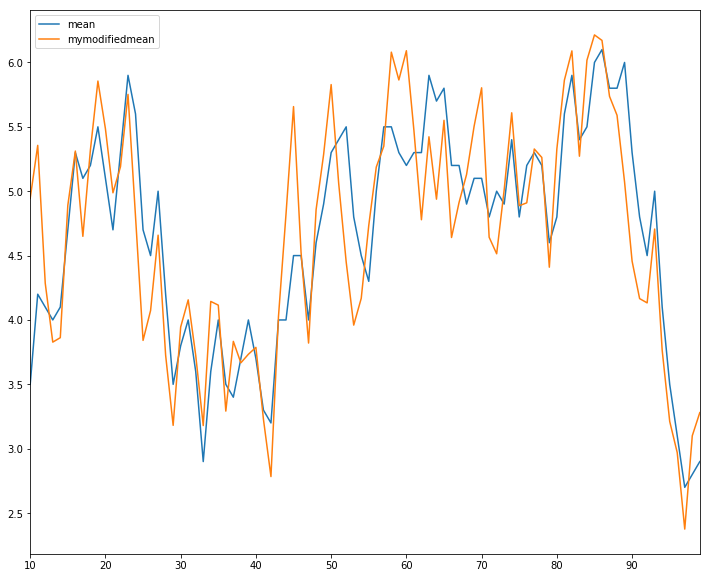

In [265]:
f, ax = pl.subplots(figsize=(12,10))
df[10:].plot(y='mean', ax=ax)
df[10:].plot(y='mymodifiedmean', ax=ax)
pl.show()

In [207]:
row['openPosition']

False

In [197]:

int(dfSMA.shortSMA[1] > dfSMA.longSMA[1] and not dfSMA.openPosition[0])

-1

In [189]:
dfSMA.head(20)

,close,shortSMA,longSMA,openPosition
2017-01-05 01:00:00,0.72822,0.727793,0.723952,False
2017-01-05 02:00:00,0.72828,0.727801,0.724126,False
2017-01-05 03:00:00,0.72925,0.727939,0.724304,False
2017-01-05 04:00:00,0.73004,0.728166,0.724457,False
2017-01-05 05:00:00,0.73083,0.728457,0.724610,False
2017-01-05 06:00:00,0.73211,0.728900,0.724768,False
2017-01-05 07:00:00,0.73023,0.729295,0.724945,False
2017-01-05 08:00:00,0.72962,0.729499,0.725091,False
2017-01-05 09:00:00,0.72924,0.729720,0.725215,False
2017-01-05 10:00:00,0.72888,0.729772,0.725373,False


In [180]:
dfSMA.close[:10].mean()

0.721803

In [43]:
df = pd.DataFrame(pri, columns=['close'])

In [150]:
df['rolling_mean'] = df.close.rolling(window=10, ).mean()

In [125]:
def sma_calc(row, window):
    print(row.shift(1))
    #print(row.name)
    if row.name == window:
        pass
        #return row.close
    else:
        window = min(window, row.name)
        sma_m_1 = row.shift(1)['sma']
        #print(row.name, row.shift(window))
        #print(row.close, row.shift(window).close, window+1)
        #sma = ((sma_m_1 * (window-1)) + row.close) / window
        sma = sma_m_1 + (row.close - row.shift(window).close )/ (window + 1) 
        #return sma

In [151]:
df.head(11)

,close,rolling_mean,sma
0,0.644571,NaN,None
1,0.544944,NaN,None
2,0.299272,NaN,None
3,0.814301,NaN,None
4,0.960409,NaN,None
5,0.063420,NaN,None
6,0.617480,NaN,None
7,0.548933,NaN,None
8,0.555980,NaN,None
9,0.445160,0.549447,None


In [98]:
f,ax=pl.subplots(figsize=(12,5))
df.plot.line(y='rolling_mean', ax=ax)
df.plot.line(y='sma', ax=ax);
pl.show()

In [27]:
class Strategy:
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def generate_signal(self):
        raise NotImplementedError("Please implement method generate_signal")

In [ ]:
class SMACross(Strategy):
    def __init__(self, bidClose, granularity='H1',
                 longWindow=20, shortWindow=5):
        self.lonWindow = np.arr
        